In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ["KERAS_BACKEND"] = "torch"

torch.set_default_device('mps')

from keras import models, layers, optimizers, losses, metrics, utils, callbacks

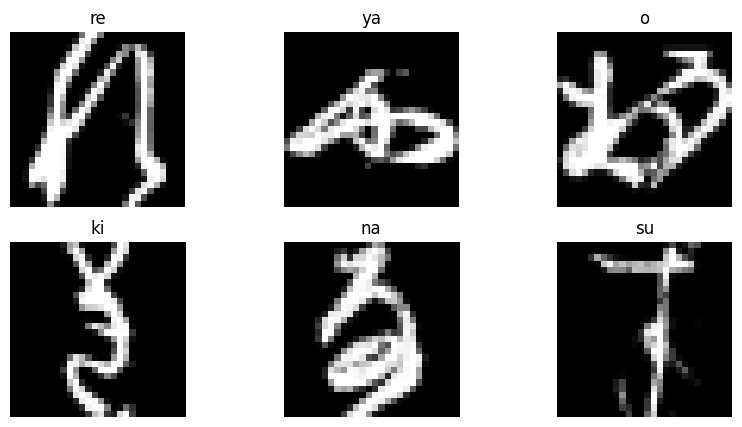

In [36]:
# KMNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = torchvision.datasets.KMNIST(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.KMNIST(
    root="./data", train=False, download=True, transform=transform
)

# Plot 6 images from the dataset
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset.data[i], cmap="gray")
    plt.title(train_dataset.classes[train_dataset.targets[i]])
    plt.axis("off")

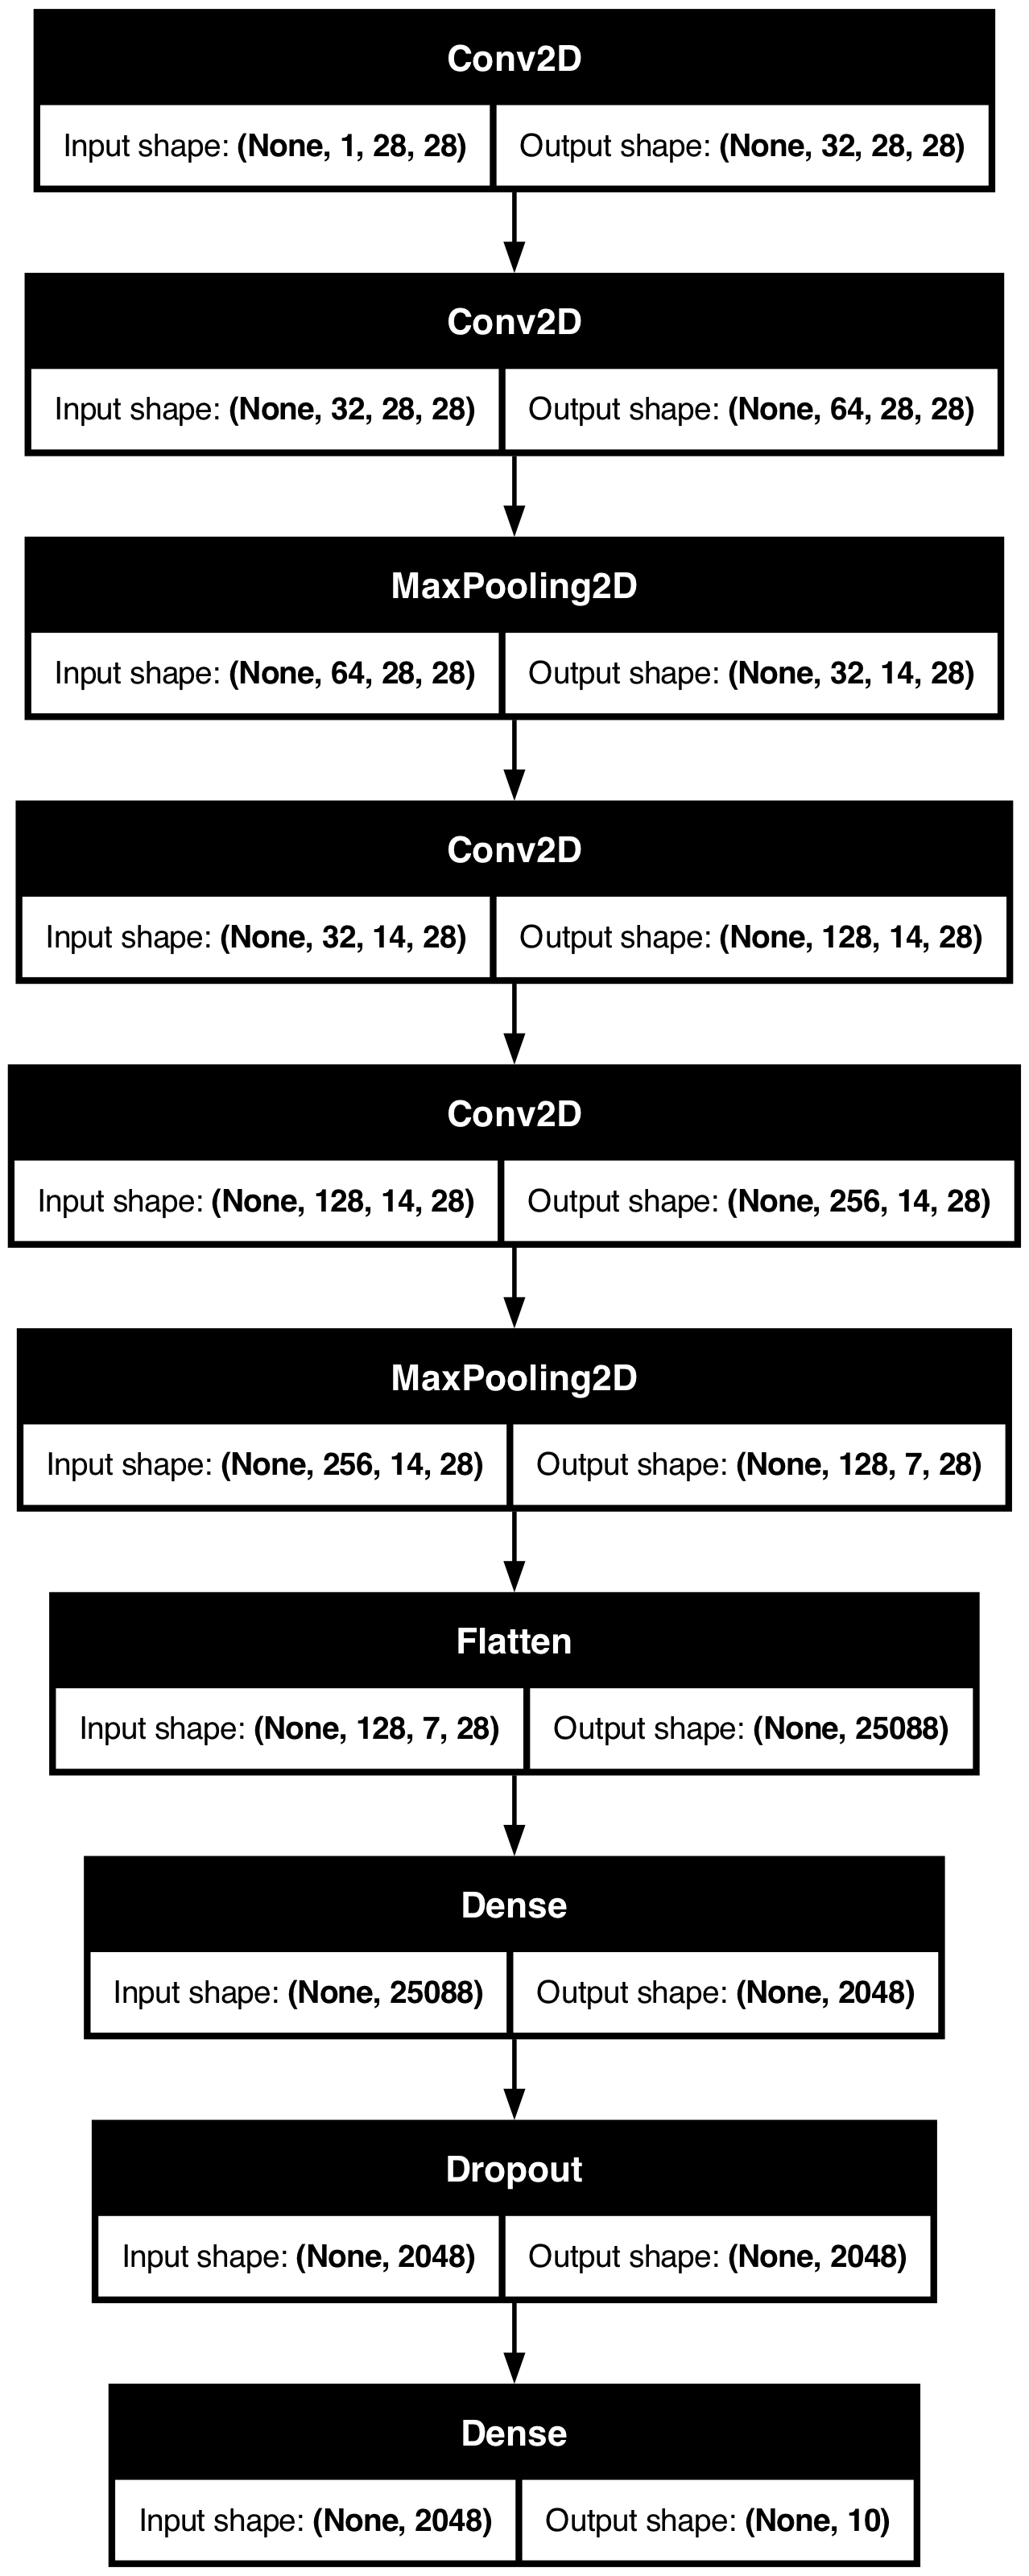

In [37]:
# Build the CNN model
input_shape = (1, 28, 28)
num_classes = 10

model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", data_format="channels_first"),
        layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", data_format="channels_first"),
        layers.MaxPooling2D(pool_size=2, strides=2),
        layers.Conv2D(128, kernel_size=3, padding="same", activation="relu", data_format="channels_first"),
        layers.Conv2D(256, kernel_size=3, padding="same", activation="relu", data_format="channels_first"),
        layers.MaxPooling2D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.8),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
utils.plot_model(model, show_shapes=True)

In [45]:
learning_rate = 0.1
batch_size = 256
epochs = 5

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='mps'))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='mps'))

In [46]:
# compiling model
lr_scheduler = optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=100000, decay_rate=0.96)
optimizer = optimizers.AdamW(learning_rate=lr_scheduler)
loss = losses.SparseCategoricalCrossentropy()
metric = metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.fit(
    train_loader,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[callbacks.EarlyStopping(monitor="loss", patience=3, restore_best_weights=True,)],
)

score = model.evaluate(test_loader, verbose=0)
score

Epoch 1/5
194/235 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 14.5430 - sparse_categorical_accuracy: 0.0977